# Pneumonia Localization

This notebook provides an interactive example of some of the function calls implemented for this project to train and infer.

In [1]:
import os
import sys
import time
import random
import collections
import numpy as np
from sklearn import metrics
import tensorflow as tf

import cv2
import matplotlib.pyplot as plt
from pprint import pprint

try:
    script_path = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_path = "/projects/lungbox/src"
    sys.path.append(script_path)
sys.path.append(script_path + "/Mask_RCNN")

import Mask_RCNN.mrcnn.model as modellib
import Mask_RCNN.mrcnn.utils as modelutils

import utils
import ingest
import visualize

from mrcnn.config import Config
from config import GlobalConfig
from config import InferenceConfig

# Set manually since not properly picked up from system config
os.environ['AWS_REGION'] = GlobalConfig.get('AWS_REGION')
MODEL_DIR = '/projects/lungbox/models'

Using TensorFlow backend.


In [2]:
# Set this to False to prevent the model from being re-trained!
TRAINING_ENABLED = False

In [3]:
# Device to load the neural network on, e.g. /cpu:0 or /gpu:0
# Set inference to CPU if GPU's are being used for training on same machine!
TRAINING_DEVICE = '/gpu:0'
INFERENCE_DEVICE = '/gpu:0'

In [4]:
%cd '/projects/lungbox'

from data import TrainingData
data = TrainingData(data_source='local',
                    subdir='train',
                    subset_size=5000, # 25684,
                    validation_split=0.2)

/projects/lungbox
Using cached image list: data/preprocessed/local_dicom_image_list.csv
Training count: 4000
Validation instance count: 1000


In [5]:
dataset_train = data.get_dataset_train()
dataset_valid = data.get_dataset_valid()
print('Image Shape: %s' % str(dataset_train.load_image(1).shape))

Image Shape: (1024, 1024, 1)


In [6]:
pct_train_pos = sum(1 for id in data.patient_id_train if len(data.annotation_dict[id]['boxes']) != 0 ) / len(data.patient_id_train)
pct_valid_pos = sum(1 for id in data.patient_id_valid if len(data.annotation_dict[id]['boxes']) != 0 ) / len(data.patient_id_valid)
print("Train Pct Positive: %s" % pct_train_pos)
print("Valid Pct Positive: %s" % pct_valid_pos)

Train Pct Positive: 0.2205
Valid Pct Positive: 0.22


## Image Sample

Image ID: 174
Patient Id: 0b2057bc-4c6d-4c90-8975-94c02392e460
Image Path: data/raw/stage_1_train_images/0b2057bc-4c6d-4c90-8975-94c02392e460.dcm
Annotations:
[[496.0, 604.0, 240.0, 273.0],
 [99.0, 211.0, 222.0, 385.0],
 [79.0, 583.0, 248.0, 256.0]]


(-0.5, 1023.5, 1023.5, -0.5)

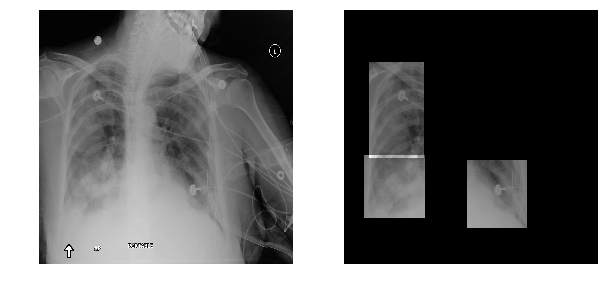

In [7]:
# Load and display random samples
# Example Positives: 174, 194, 335, 348
# Example Negatives: 958, 3170, 3410, 3813

image_id = 174  # random.choice(dataset_train.image_ids) 
print('Image ID: {}'.format(image_id))
print('Patient Id: {}'.format(dataset_train.patient_ids[174]))
print('Image Path: {}'.format(dataset_train.get_image_reference(image_id=174)))
print('Annotations:')
pprint(dataset_train.get_image_annotation(image_id=174))

# Load image and mask
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

# Plot image and mask
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

In [8]:
print('Training dataset bounding box representation')
print('{:>12}{:>6}{:>6}{:>6}'.format('x1', 'y1', 'x2', 'y2'))
pprint(np.array(dataset_train.get_image_annotation(174)))

Training dataset bounding box representation
          x1    y1    x2    y2
array([[496., 604., 240., 273.],
       [ 99., 211., 222., 385.],
       [ 79., 583., 248., 256.]])


(-0.5, 1023.5, 1023.5, -0.5)

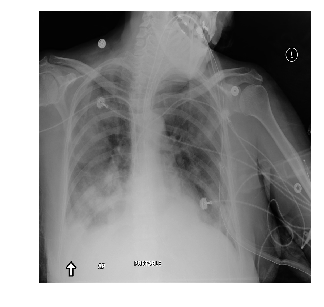

In [9]:
image_id = 174
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
plt.figure(figsize=(5, 5))
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

## Model Training

In [10]:
class DetectorConfig11a(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    NAME = 'pneumonia'
    GPU_COUNT = 4
    IMAGES_PER_GPU = 2             # batch size = 1*2 = 2
    TRAIN_SAMPLE_SIZE = 5000*0.8
    VALID_SAMPLE_SIZE = 5000*0.2
    BATCH_SIZE = GPU_COUNT*IMAGES_PER_GPU
    BACKBONE = 'resnet101'
    NUM_CLASSES = 2                # background + 1 pneumonia classes
    MAX_GT_INSTANCES = 4           # up to 4 bounding boxes per image
    IMAGE_RESIZE_MODE = 'none'     # No resizing or padding. Return the image unchanged.
    IMAGE_MIN_DIM = 1024           # preserve original 1024 dimension
    IMAGE_MAX_DIM = 1024           # preserve original 1024 dimension
    IMAGE_CHANNEL_COUNT = 1        # grayscale
    MEAN_PIXEL = np.array([127.5]) # mean pixel intensity
    
    STEPS_PER_EPOCH = TRAIN_SAMPLE_SIZE // BATCH_SIZE
    VALIDATION_STEPS = VALID_SAMPLE_SIZE // BATCH_SIZE
    
    # How many anchors per image to use for RPN training
    # Set according to the Faster R-CNN paper, Section 3.1.3, Training RPNs.
    # default: 256 appears arbitrary. Treat this as a hyper-parameter.
    RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    
    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # Non-max suppression threshold to filter RPN proposals.
    RPN_NMS_THRESHOLD = 0.9        # default: 0.7; increase to generate more proposals.

    # Training ROIs kept after non-maximum suppression
    POST_NMS_ROIS_TRAINING = 2400
    
    # Number of ROIs per image to feed to classifier/mask heads
    TRAIN_ROIS_PER_IMAGE = 256
    ROI_POSITIVE_RATIO = 0.33      # default: 0.33
    
    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.002          # default: 0.001
    LEARNING_MOMENTUM = 0.9        # default: 0.9

    
train_config_11a = DetectorConfig11a()

In [11]:
# Train Mask-RCNN Model
elapsed_start = time.perf_counter()
model = modellib.MaskRCNN(mode='training',
                          config=train_config_11a,
                          model_dir=MODEL_DIR)
print("TRAINING_ENABLED: %s" % TRAINING_ENABLED)
if TRAINING_ENABLED:
    with tf.device(TRAINING_DEVICE):
        model.train(dataset_train, dataset_valid, 
                    learning_rate=train_config_11a.LEARNING_RATE, 
                    epochs=train_config_11a.NUM_EPOCHS,
                    #augmentation=augmentation,
                    layers='all')
elapsed_end = time.perf_counter()
print('Training Time: %ss' % round(elapsed_end - elapsed_start, 4)) # 550 (9.5m/epoch)

TRAINING_ENABLED: False
Training Time: 18.9253s


## Model Inference

In [61]:
class InferenceConfig11a(DetectorConfig11a):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1                # batch size = 1*2 = 2
    DETECTION_MIN_CONFIDENCE = 0.975  # positive class confidence threshold
    DETECTION_MAX_INSTANCES = 4       # up to 4 true boxes per image
    DETECTION_NMS_THRESHOLD = 0.1

infer_config_11a = InferenceConfig11a()

In [62]:
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset=dataset_train, config=infer_config_11a,
                           image_id=174, augment=False, use_mini_mask=False) 
print('Internal bounding box representation')
print('{:>11}{:>5}{:>5}{:>5}'.format('y1', 'x1', 'y2', 'x2'))
pprint(gt_bbox)

Internal bounding box representation
         y1   x1   y2   x2
array([[604, 496, 878, 737],
       [211,  99, 597, 322],
       [583,  79, 840, 328]], dtype=int32)


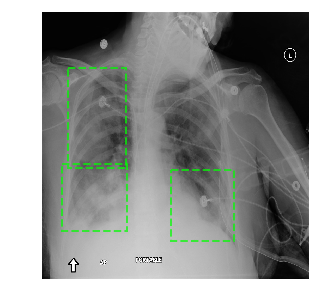

In [63]:
visualize.display_boxes(image=original_image, boxes=gt_bbox, figsize=(5, 5))

In [64]:
model = modellib.MaskRCNN(mode='inference', 
                          config=infer_config_11a,
                          model_dir=MODEL_DIR)

In [65]:
# Latest should be
# /projects/lungbox/models/pneumonia20181003T1228/mask_rcnn_pneumonia_0050.h5
# model_path = utils.find_latest_model(MODEL_DIR, 'mask_rcnn_pneumonia',
#                                      inference_config = infer_config_11a)
model_path = '/projects/lungbox/models/pneumonia20181003T1228/mask_rcnn_pneumonia_0050.h5'

In [66]:
# Load weights
# Note that the conv1 layer should NOT be excluded despite being grayscale.
model.load_weights(model_path, by_name=True)

Re-starting from epoch 50


Processing 1 images
image                    shape: (1024, 1024, 1)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 1)    min: -127.50000  max:  127.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


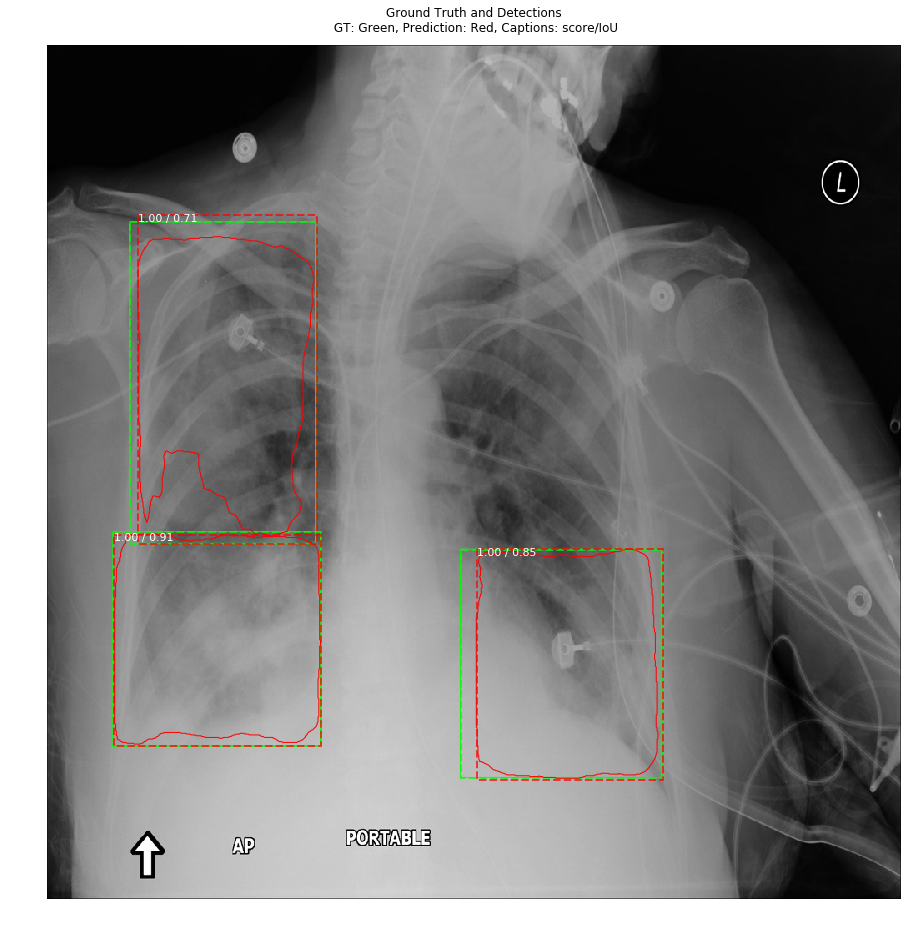

In [69]:
visualize.display_differences_by_id(model, dataset_train, infer_config_11a, image_id=174)

### Training Set Examples

Image ID: 326
Processing 1 images
image                    shape: (1024, 1024, 1)       min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 1)    min: -127.50000  max:  114.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Image ID: 1126

*** No instances to display *** 

Processing 1 images
image                    shape: (1024, 1024, 1)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 1)    min: -127.50000  max:  116.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32

*** No instances to display *** 

Image ID: 3871

*** No instances to display *** 

Processing 1 images
image                    shape:

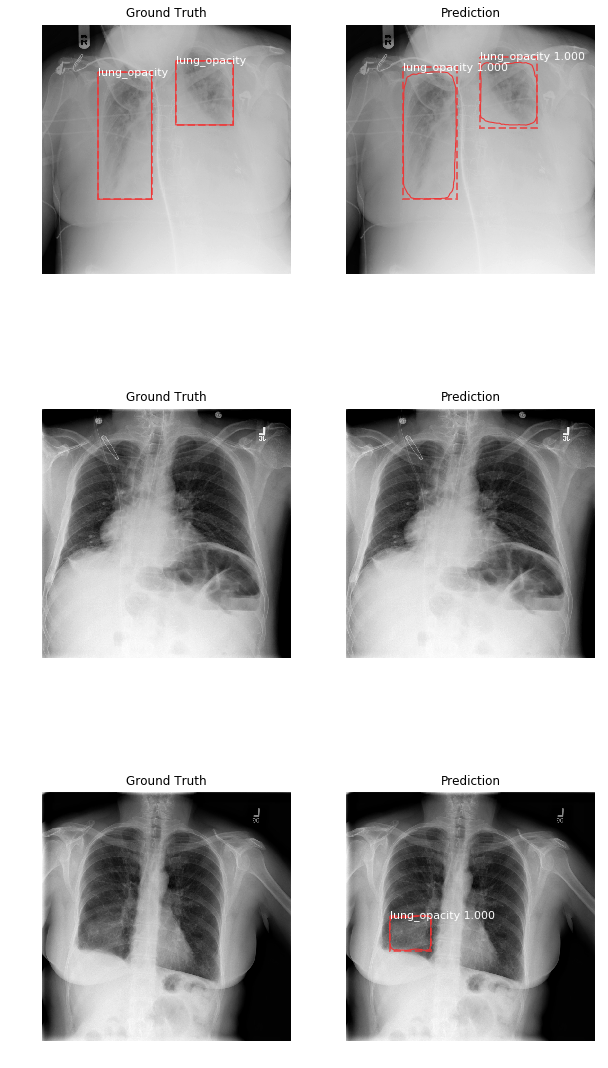

In [70]:
visualize.show_randoms(model, dataset_train, infer_config_11a, n_images=3)

### Validation Set Examples

Image ID: 11
Processing 1 images
image                    shape: (1024, 1024, 1)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 1)    min: -127.50000  max:  127.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Image ID: 908

*** No instances to display *** 

Processing 1 images
image                    shape: (1024, 1024, 1)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 1)    min: -127.50000  max:  127.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32

*** No instances to display *** 

Image ID: 840

*** No instances to display *** 

Processing 1 images
image                    shape: (1

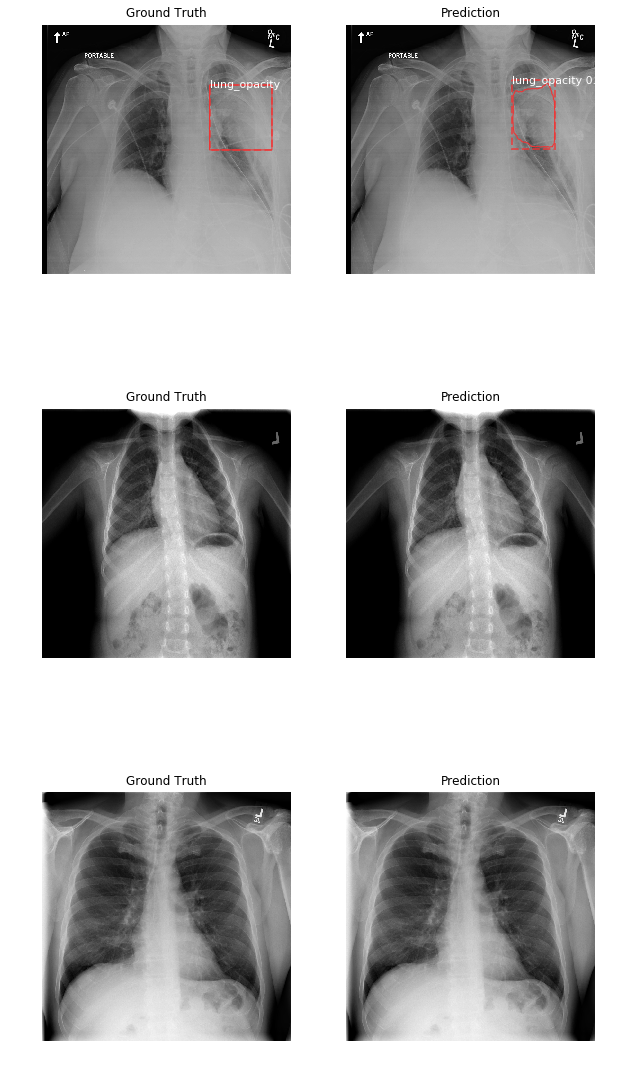

In [72]:
visualize.show_randoms(model, dataset_valid, infer_config_11a, n_images=3)

## Model Metrics

In [74]:
# For a faster results on a random sample:
# list(random.sample(range(len(dataset_valid.patient_ids)), k=100)))
result_train = compute_batch_metrics(
    model=model,
    dataset=dataset_train,
    inference_config=infer_config_11a,
    image_ids=list(random.sample(range(len(dataset_train.patient_ids)), k=100)))
    # image_ids=range(len(dataset_train.patient_ids)))

Processing image id: 92
Ground Truth Classes: [1 1 1]
Predicted Classes: [1 1 1]
Predicted Scores: [0.99970895 0.99829453 0.9857302 ]
Class Result: tp
Overlap: 
[[0.853777  0.        0.       ]
 [0.        0.8423685 0.       ]
 [0.        0.        0.866035 ]]


Processing image id: 3022
Ground Truth Classes: []
Predicted Classes: []
Predicted Scores: []
Class Result: tn
Overlap: 
[]


Processing image id: 3256
Ground Truth Classes: []
Predicted Classes: []
Predicted Scores: []
Class Result: tn
Overlap: 
[]


Processing image id: 2528
Ground Truth Classes: []
Predicted Classes: [1]
Predicted Scores: [0.99674547]
Class Result: fp
Overlap: 
[[0.]]


Processing image id: 2689
Ground Truth Classes: []
Predicted Classes: []
Predicted Scores: []
Class Result: tn
Overlap: 
[]


Processing image id: 3755
Ground Truth Classes: []
Predicted Classes: [1]
Predicted Scores: [0.99998236]
Class Result: fp
Overlap: 
[[0.]]


Processing image id: 3549
Ground Truth Classes: []
Predicted Classes: []
Pred

Ground Truth Classes: []
Predicted Classes: [1]
Predicted Scores: [0.9924569]
Class Result: fp
Overlap: 
[[0.]]


Processing image id: 1616
Ground Truth Classes: []
Predicted Classes: [1]
Predicted Scores: [0.9772874]
Class Result: fp
Overlap: 
[[0.]]


Processing image id: 81
Ground Truth Classes: [1]
Predicted Classes: [1]
Predicted Scores: [0.99999654]
Class Result: tp
Overlap: 
[[0.937698]]


Processing image id: 3056
Ground Truth Classes: []
Predicted Classes: []
Predicted Scores: []
Class Result: tn
Overlap: 
[]


Processing image id: 497
Ground Truth Classes: [1 1]
Predicted Classes: [1 1]
Predicted Scores: [0.9999976  0.99987316]
Class Result: tp
Overlap: 
[[0.         0.71893847]
 [0.6175528  0.        ]]


Processing image id: 499
Ground Truth Classes: [1]
Predicted Classes: [1]
Predicted Scores: [0.9990583]
Class Result: tp
Overlap: 
[[0.9326281]]


Processing image id: 2357
Ground Truth Classes: []
Predicted Classes: []
Predicted Scores: []
Class Result: tn
Overlap: 
[]


P

### At an inference threshold of 0.50 with a random sample of n=100:

In [36]:
scores = []
y = []
for k, v in result_train.items():
    for i, pred_score in enumerate(v['pred_scores']):
        scores.append(pred_score)
        y.append(np.max(v['overlaps'][i] > 0))
        # print(pred_score, np.max(v['overlaps'][i]))

precision, recall, pr_thresholds = metrics.precision_recall_curve(np.array(y), np.array(scores), pos_label=True)
fpr, tpr, roc_thresholds = metrics.roc_curve(np.array(y), np.array(scores), pos_label=True)

In [32]:
train_class_counts = collections.Counter(v['class_result'] for k, v in result_train.items())
print("Train: %s" % train_class_counts)
utils.summarize_cm(train_class_counts)

Train: Counter({'fp': 76, 'tp': 20, 'tn': 4})
Accuracy: 0.24
Recall: 1.0
Precision: 0.20833333333333334
F1: 0.3448275862068966


{'accuracy': 0.24,
 'recall': 1.0,
 'precision': 0.20833333333333334,
 'f1': 0.3448275862068966}

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

No handles with labels found to put in legend.


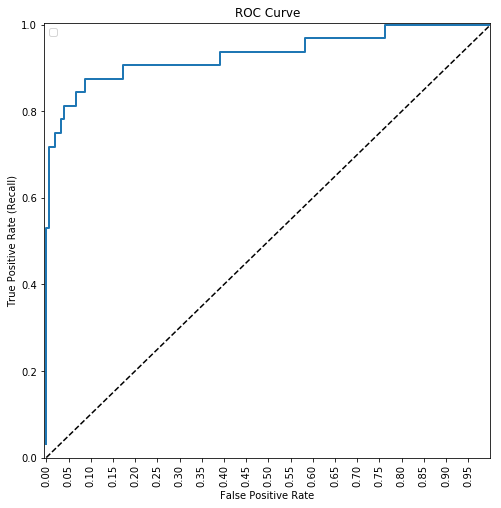

In [54]:
plot_roc_curve(fpr, tpr)

In [42]:
metrics.auc(fpr, tpr)

0.931498344370861

In [48]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall vs. Inference Threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

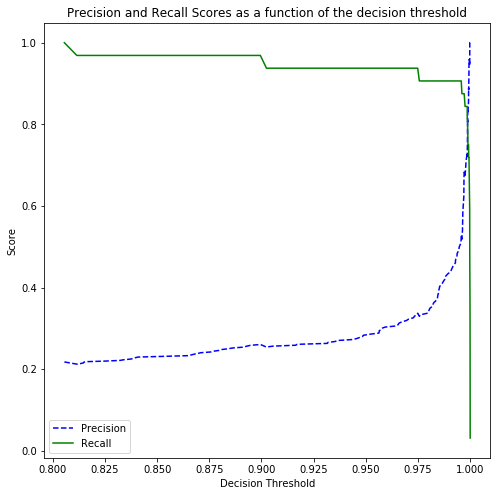

In [51]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

### At an inference threshold of 0.975:

In [76]:
scores = []
y = []
for k, v in result_train.items():
    for i, pred_score in enumerate(v['pred_scores']):
        scores.append(pred_score)
        y.append(np.max(v['overlaps'][i] > 0))
        # print(pred_score, np.max(v['overlaps'][i]))

precision, recall, pr_thresholds = metrics.precision_recall_curve(np.array(y), np.array(scores), pos_label=True)
fpr, tpr, roc_thresholds = metrics.roc_curve(np.array(y), np.array(scores), pos_label=True)

In [77]:
train_class_counts = collections.Counter(v['class_result'] for k, v in result_train.items())
print("Train: %s" % train_class_counts)
utils.summarize_cm(train_class_counts)

Train: Counter({'fp': 41, 'tn': 36, 'tp': 23})
Accuracy: 0.59
Recall: 1.0
Precision: 0.359375
F1: 0.5287356321839081


{'accuracy': 0.59,
 'recall': 1.0,
 'precision': 0.359375,
 'f1': 0.5287356321839081}

In [78]:
metrics.auc(fpr, tpr)

0.8974137931034482